# Vancouver Housing distribution map

This notebook will show the distribution of houses for sale in each neighborhood in Vancouver.And will also count the total facilities in each neighborhood. 

In [125]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
import geopandas as gpd
%pip install folium
import folium
from shapely.geometry import Point
from shapely import wkt

# Configure Notebook
#for plots to be inline
%matplotlib inline 
#for auto_complete 
%config Completer.use_jedi = False 


Note: you may need to restart the kernel to use updated packages.


Let's add similiar nearby feature together into one CSV file

In [138]:
# restaurant
cafe = pd.read_csv('van-cafe.csv') 
restruarents = pd.read_csv('vancouver_Pubs and restuarents.csv')
fastfood = pd.read_csv('van-fast_food.csv')
combined_csv = pd.concat([cafe, restruarents, fastfood ], axis=0, ignore_index=True)
combined_csv.to_csv('combined_resturants_van.csv', index=False)

# Public Service
hospital = pd.read_csv('vancouver_Hospitals.csv') 
park = pd.read_csv('van-parks.csv') 
school = pd.read_csv('vancouver_Schools_university_colleges.csv') 
combined_csv2 = pd.concat([hospital, park, school ], axis=0, ignore_index=True)
combined_csv2.to_csv('combined_Public_Service_van.csv', index=False)

# Public Transit
bus = pd.read_csv('vancouver_Bus Stations and Bus Stops.csv') 
rail = pd.read_csv('vancouver_Railway Stations and  Railway Stops.csv') 
combined_csv3 = pd.concat([bus, rail ], axis=0, ignore_index=True)
combined_csv3.to_csv('combined_Public_transit_van.csv', index=False)

# Other dailylife
kindergardens =  pd.read_csv('van-kindergartens.csv')
malls= pd.read_csv('van-malls.csv')
post_office= pd.read_csv('van-post_office.csv')
dental= pd.read_csv('van-dentist.csv')
supermarket =  pd.read_csv('vancouver_Supermarkets.csv')
combined_csv4 = pd.concat([kindergardens, post_office, dental, supermarket ], axis=0, ignore_index=True)
combined_csv4.to_csv('combined_Other_dailylife_van.csv', index=False)


In [140]:
# Import data
neighbourhoods = gpd.read_file('local-area-boundary_van.geojson') 

restruarent = pd.read_csv('combined_resturants_van.csv')
public_service = pd.read_csv('combined_Public_Service_van.csv')
public_transit = pd.read_csv('combined_Public_transit_van.csv')
other = pd.read_csv('combined_Other_dailylife_van.csv')

van_1500 = pd.read_csv('Vancouver_Houses_Facilities_1.5km.csv')
van_1000 = pd.read_csv('Vancouver_Houses_Facilities_1km.csv')
van_500 = pd.read_csv('Vancouver_Houses_Facilities_0.5km.csv')

house_data = pd.read_csv('housing_van_clean_with_best_buffers_v2.3.csv')


neighbourhoods.head()

,name,geo_point_2d,geometry
0,Downtown,"{ ""lon"": -123.11656700827415, ""lat"": 49.280747...","POLYGON ((-123.11 49.29, -123.1 49.288, -123.1..."
1,Hastings-Sunrise,"{ ""lon"": -123.04026992328848, ""lat"": 49.277934...","POLYGON ((-123.06 49.293, -123.05 49.294, -123..."
2,Kerrisdale,"{ ""lon"": -123.15957618168902, ""lat"": 49.223655...","POLYGON ((-123.18 49.216, -123.18 49.215, -123..."
3,Marpole,"{ ""lon"": -123.1283816596551, ""lat"": 49.2102074...","POLYGON ((-123.11 49.204, -123.11 49.204, -123..."
4,Oakridge,"{ ""lon"": -123.12302460370566, ""lat"": 49.226403...","POLYGON ((-123.11 49.233, -123.11 49.219, -123..."


In [142]:
# Drop all columns except for 'geometry', and 'FIELD_8'
neighbourhoods = neighbourhoods[['geometry', 'name']] 
# Rename
neighbourhoods = neighbourhoods.rename(columns={'name': 'neighbourhood'})
# Split the name column at '(' and only keep the name
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.split('(').str[0] 
# Remove any leading or trailing spaces and lower case the neighbourhood
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.strip() 
neighbourhoods['neighbourhood'] = neighbourhoods['neighbourhood'].str.lower()


# View GeoDataFrame
neighbourhoods.head()

,geometry,neighbourhood
0,"POLYGON ((-123.11 49.29, -123.1 49.288, -123.1...",downtown
1,"POLYGON ((-123.06 49.293, -123.05 49.294, -123...",hastings-sunrise
2,"POLYGON ((-123.18 49.216, -123.18 49.215, -123...",kerrisdale
3,"POLYGON ((-123.11 49.204, -123.11 49.204, -123...",marpole
4,"POLYGON ((-123.11 49.233, -123.11 49.219, -123...",oakridge


In [144]:


# Transform neighbourhoods to EPSG:26917
neighbourhoods = neighbourhoods.to_crs(epsg=26917)

# Calculate the area in square kilometers
neighbourhoods['area'] = neighbourhoods.geometry.area / 1e6  # Convert from square meters to square kilometers

# View GeoDataFrame
neighbourhoods.head()

,geometry,neighbourhood,area
0,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",downtown,5.782060
1,"POLYGON ((-2.49e+06 6.37e+06, -2.49e+06 6.37e+...",hastings-sunrise,10.300109
2,"POLYGON ((-2.51e+06 6.37e+06, -2.51e+06 6.37e+...",kerrisdale,8.182961
3,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",marpole,7.431784
4,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",oakridge,4.980075


In [146]:
# House
# Convert to 4326
house_gdf = gpd.GeoDataFrame(
    house_data,
    geometry=gpd.points_from_xy(house_data['longitude'], house_data['latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
house_gdf = house_gdf.to_crs(epsg=26917)


# Restaurants
restruarents_gdf = gpd.GeoDataFrame(
    restruarent,
    geometry=gpd.points_from_xy(restruarent['Longitude'], restruarent['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
restruarents_gdf= restruarents_gdf.to_crs(epsg=26917)

# Public Service
public_service_gdf = gpd.GeoDataFrame(
    public_service,
    geometry=gpd.points_from_xy(public_service['Longitude'], public_service['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
public_service_gdf= public_service_gdf.to_crs(epsg=26917)

# Public Transit
public_transit_gdf = gpd.GeoDataFrame(
    public_transit,
    geometry=gpd.points_from_xy(public_transit['Longitude'], public_transit['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
public_transit_gdf= public_transit_gdf.to_crs(epsg=26917)

#Other
other_gdf = gpd.GeoDataFrame(
    other,
    geometry=gpd.points_from_xy(other['Longitude'], other['Latitude']),
    crs="EPSG:4326"
)

# Match the neighbourhoods' CRS (epsg:26917)
other_gdf= other_gdf.to_crs(epsg=26917)

house_data.head()


,neighbourhood,unnamed: 0,street address,latitude,longitude,geometry,price,bedrooms,bathrooms,total_crimes (2020-2024),...,bus stop_best_buffer_area_1.5_values,pub_best_buffer_area_0.5_values,restaurant_best_buffer_area_1.5_values,cafe_best_buffer_area_1.5_values,dentist_best_buffer_area_0.5_values,fast food_best_buffer_area_1.5_values,kindergartens_best_buffer_area_0.5_values,malls_best_buffer_area_0.5_values,play ground_best_buffer_area_0.5_values,post office_best_buffer_area_1.0_values
0,arbutus ridge,38,2795 w 37th ave,49.238765,-123.167839,point (-123.167839 49.238765),5750000,5,7,1417,...,46,0,23,8,0,4,0,0,0,1
1,arbutus ridge,78,4422 quesnel dr,49.247018,-123.168268,point (-123.168268 49.247018),8680000,5,6,1417,...,47,0,3,1,0,2,0,0,0,0
2,arbutus ridge,125,4101 yew st #304,49.248583,-123.155246,point (-123.155246 49.248583),699900,1,1,1417,...,50,0,8,4,0,4,0,0,0,0
3,arbutus ridge,175,2556 w 20th ave,49.254284,-123.163295,point (-123.163295 49.254284),4290000,6,5,1417,...,73,0,30,12,0,9,0,0,0,0
4,arbutus ridge,184,2638 w 22nd ave,49.252494,-123.164150,point (-123.16415 49.252494),5780000,4,5,1417,...,69,0,20,10,0,7,0,0,0,0


In [148]:
# add new column that represents House, restaurants, public service , public transit and other in each neighbourhoods
neighbourhoods['house_counts'] = neighbourhoods.apply(lambda row: house_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['house_counts'] = neighbourhoods.apply(lambda row: house_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['restruarent_counts'] = neighbourhoods.apply(lambda row: restruarents_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['public_service_counts'] = neighbourhoods.apply(lambda row: public_service_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['public_transit_counts'] = neighbourhoods.apply(lambda row: public_transit_gdf.within(row.geometry).sum(),axis = 1)
neighbourhoods['other_counts'] = neighbourhoods.apply(lambda row: other_gdf.within(row.geometry).sum(),axis = 1)# sort value with descending order
neighbourhoods = neighbourhoods.sort_values('house_counts', ascending = False)
neighbourhoods['house_density'] = neighbourhoods['house_counts'] / neighbourhoods['area']


neighbourhoods[['neighbourhood', 'geometry','area','house_counts', 'house_density', 'restruarent_counts', 'public_service_counts',
               'public_transit_counts', 'other_counts']].head(10)

,neighbourhood,geometry,area,house_counts,house_density,restruarent_counts,public_service_counts,public_transit_counts,other_counts
0,downtown,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",5.782060,237,40.988853,656,33,179,28
18,kitsilano,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",7.875231,82,10.412394,195,2,89,20
10,fairview,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",4.498265,80,17.784637,177,16,78,15
16,kensington-cedar cottage,"POLYGON ((-2.49e+06 6.36e+06, -2.5e+06 6.36e+0...",8.970721,76,8.472006,133,1,124,13
11,mount pleasant,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",4.602341,75,16.296056,154,5,72,11
13,west end,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",2.791365,72,25.793830,268,9,51,18
12,renfrew-collingwood,"POLYGON ((-2.49e+06 6.36e+06, -2.49e+06 6.36e+...",10.016662,61,6.089853,88,1,161,6
1,hastings-sunrise,"POLYGON ((-2.49e+06 6.37e+06, -2.49e+06 6.37e+...",10.300109,54,5.242663,57,1,98,4
7,shaughnessy,"POLYGON ((-2.5e+06 6.37e+06, -2.5e+06 6.37e+06...",5.545281,45,8.115008,6,1,54,1
5,riley park,"POLYGON ((-2.5e+06 6.36e+06, -2.5e+06 6.36e+06...",6.102006,44,7.210743,91,2,71,3


In [150]:
# Use spatial join to match each property with its neighbourhood
house_merged = gpd.sjoin(house_gdf, neighbourhoods[['neighbourhood', 'geometry', 'area', 'house_density','restruarent_counts', 'public_service_counts',
               'public_transit_counts', 'other_counts']], how='left', predicate='within')
house_merged.head()

,neighbourhood_left,unnamed: 0,street address,latitude,longitude,geometry,price,bedrooms,bathrooms,total_crimes (2020-2024),...,play ground_best_buffer_area_0.5_values,post office_best_buffer_area_1.0_values,index_right,neighbourhood_right,area,house_density,restruarent_counts,public_service_counts,public_transit_counts,other_counts
0,arbutus ridge,38,2795 w 37th ave,49.238765,-123.167839,POINT (-2.5e+06 6.37e+06),5750000,5,7,1417,...,0,1,14,arbutus ridge,4.581059,5.457253,27,1,47,5
1,arbutus ridge,78,4422 quesnel dr,49.247018,-123.168268,POINT (-2.5e+06 6.37e+06),8680000,5,6,1417,...,0,0,14,arbutus ridge,4.581059,5.457253,27,1,47,5
2,arbutus ridge,125,4101 yew st #304,49.248583,-123.155246,POINT (-2.5e+06 6.37e+06),699900,1,1,1417,...,0,0,14,arbutus ridge,4.581059,5.457253,27,1,47,5
3,arbutus ridge,175,2556 w 20th ave,49.254284,-123.163295,POINT (-2.5e+06 6.37e+06),4290000,6,5,1417,...,0,0,14,arbutus ridge,4.581059,5.457253,27,1,47,5
4,arbutus ridge,184,2638 w 22nd ave,49.252494,-123.164150,POINT (-2.5e+06 6.37e+06),5780000,4,5,1417,...,0,0,14,arbutus ridge,4.581059,5.457253,27,1,47,5


# Map Plot 

This section will display a map of Vancouver showing the locations of houses for sale and the density of house sales in each neighborhood.

In [114]:
from folium import Choropleth

In [116]:

# Remove rows where house_density is 0
neighbourhoods = neighbourhoods[neighbourhoods['house_density'] != 0]

In [118]:
plot_geography = neighbourhoods.to_crs(epsg=4326)[['neighbourhood', 'geometry']]
plot_geography = plot_geography.set_index('neighbourhood')
plot_geography.head()

,geometry
neighbourhood,
downtown,"POLYGON ((-123.11 49.29, -123.1 49.288, -123.1..."
kitsilano,"POLYGON ((-123.14 49.275, -123.14 49.273, -123..."
fairview,"POLYGON ((-123.15 49.257, -123.15 49.272, -123..."
kensington-cedar cottage,"POLYGON ((-123.06 49.262, -123.06 49.243, -123..."
mount pleasant,"POLYGON ((-123.1 49.269, -123.1 49.267, -123.1..."


In [120]:
plot_data = neighbourhoods[['neighbourhood', 'house_density']]
plot_data.head()

,neighbourhood,house_density
0,downtown,40.988853
18,kitsilano,10.412394
10,fairview,17.784637
16,kensington-cedar cottage,8.472006
11,mount pleasant,16.296056


In [61]:
# Create a map centered on Vancouver
map_vancouver = folium.Map(location=[49.2827, -123.1207], 
                           tiles='cartodbpositron',
                           zoom_start=10)

# Add a choropleth map to the base map
Choropleth(geo_data=plot_geography.__geo_interface__, 
           columns=['neighbourhood', 'house_density'],
           data=plot_data, 
           key_on='feature.id', 
           fill_color='YlOrRd', 
           legend_name='House Density (house / km²)'
          ).add_to(map_vancouver)

map_vancouver

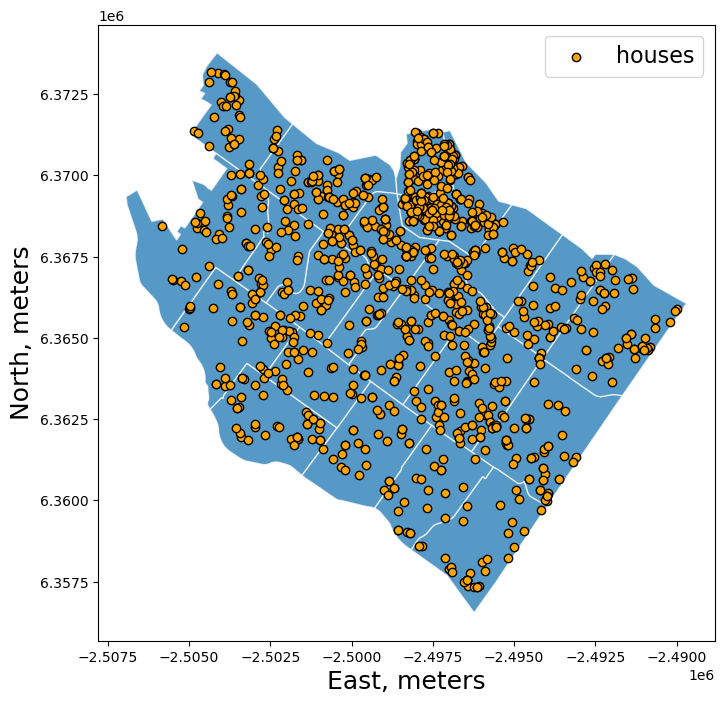

In [63]:
ax = neighbourhoods.plot(figsize=(15, 8), edgecolor='w', alpha=0.75)
house_gdf.plot(ax=ax, color='orange', edgecolor='k', label='houses')
plt.legend(fontsize=16)
plt.xlabel('East, meters', fontsize=18)
plt.ylabel('North, meters', fontsize=18);

In [65]:
from folium.plugins import HeatMap

In [67]:
# Create a map of Toronto
map_2 = folium.Map(location=[49.2827, -123.1207], 
                           tiles='cartodbpositron',
                           zoom_start=10)

# Add points to the map
HeatMap(data=list(zip(house_gdf.to_crs(epsg=4326).geometry.y,
                      house_gdf.to_crs(epsg=4326).geometry.x)),
        radius=20).add_to(map_2)

# Display map
map_2

## Calculate the total facilities around each house 

In [152]:
van_1500['Total Facilities 1500'] = van_1500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_1000['Total Facilities 1000'] = van_1000[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_500['Total Facilities 500'] = van_500[
    [
        'Hospital in area', 
        'Railway Station in area', 
        'School in area', 
        'Supermarket in area', 
        'Bus Stop in area', 
        'Pub in area', 
        'Restaurant in area',  
        'Cafe in area', 
        'Dentist in area', 
        'Fast Food in area', 
        'Kindergartens in area', 
        'Malls in area',  
        'Play Ground in area',  
        'Parks in area',  
        'Post Office in area'
    ]
].sum(axis=1)

van_500['street address'] = van_500['Street address'].str.lower()
van_1000['street address'] = van_1000['Street address'].str.lower()
van_1500['street address'] = van_1500['Street address'].str.lower()


house_merged = house_merged.merge(van_500[['street address', 'Total Facilities 500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_500m'))


house_merged = house_merged.merge(van_1000[['street address', 'Total Facilities 1000']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1000m'))


house_merged = house_merged.merge(van_1500[['street address', 'Total Facilities 1500']], 
                                  on='street address', 
                                  how='left', 
                                  suffixes=('', '_1500m'))

# Renaming the columns for clarity
house_merged.rename(columns={
    'Total Facilities_500m': 'Total Facilities within 500m',
    'Total Facilities_1000m': 'Total Facilities within 1000m',
    'Total Facilities_1500m': 'Total Facilities within 1500m'
}, inplace=True)


house_merged.to_csv('final_merged_van.csv')
